# Simple predictions of successful funding - logistic regression

### _Lukas Vlcek_

## 1. Introduction

Kickstarter records contain more than 200,000 projects, with information about the ultimate success or failure of their funding campaign, the type of the proposed work, country of origin, or amounts of money asked and pledged by funders.

## 2. Data setup

Notebook configuration

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

Create a dataframe from a pre-processed CSV file and filter out uninformative features

In [2]:
target_path = '../data/processed'
report_path = '../reports'
filename = 'kick_id.csv'
datecols = ['created_at', 'deadline', 'state_changed_at', 'launched_at']
fdatpars = lambda x: datetime.datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')
df = pd.read_csv(os.path.join(target_path, filename), index_col='id', parse_dates=datecols, date_parser=fdatpars)

Filter out unneeded data and add some indicator features

In [3]:
df = df.drop(['disable_communication'], axis='columns')
df = df.loc[(df['state'] != 'live') & (df['state'] != 'suspended')]
cat_type = [x.split('/')[0] for x in df['category'].values]
df['cat_type'] = np.array(cat_type)
df['dummy'] = 1
df['period'] = (df['launched_at'] >= '2014-06-01') & (df['launched_at'] < '2018-01-01')
df['succeeded'] = np.int_(df['state'] == 'successful')
df['staff_pick'] = np.int_(df['staff_pick'])
df.sort_values('launched_at').loc[df.period]['launched_at'].shape

(149007,)

In [4]:
# counting words in project names and blurbs
df.loc[df['blurb'].isnull(), 'blurb'] = ''
df.loc[df['name'].isnull(), 'name'] = ''
df['blurb_wlen'] = df['blurb'].str.split().apply(len)
df['name_wlen'] = df['name'].str.split().apply(len)

In [5]:
# make new dataframes with new and old data
dfn = df.loc[df.period].copy()
dfo = df.loc[~df.period].copy()
dfn.shape, dfo.shape

((149007, 23), (89449, 23))

In [6]:
# take logarithm of goals
dfn['goal_log'] = np.log10(dfn['goal'].values)

In [159]:
# drop unwanted columns
dfm = dfn.drop(['usd_pledged','goal','state','slug','currency','deadline','state_changed_at','created_at','backers_count','spotlight','period'], axis=1).copy()
# get dummies
dfd = pd.get_dummies(dfm, columns=['country','cat_type'])

## 3. Modeling

In [175]:
# ML imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.base import TransformerMixin, BaseEstimator, clone
from sklearn.pipeline import Pipeline, FeatureUnion

Select predictor and target columns for model fitting

In [281]:
predictors_nt = []
predictors_nt.extend([c for c in dfd.columns if c[0:5] == 'cat_t' ])
predictors_nt.extend(['goal_log', 'name_wlen'])
#predictors.extend(['goal_log', 'staff_pick','name_wlen'])

predictors_text = []
predictors_text.extend(['name', 'blurb'])

predictors = predictors_nt + predictors_text

target = ['succeeded']

Train-test split for pandas dataframe

In [205]:
df_train=dfd.sample(frac=0.8,random_state=200)
df_test=dfd.drop(df_train.index)

In [338]:
# Training dataset
Xtrain = df_train[predictors]
ytrain = df_train[target].values.astype(np.int).flatten() 

# Testing dataset
Xtest = df_test[predictors]
ytest = df_test[target].values.astype(np.int).flatten() 

### 3.1 Create a pipeline

1. Textual features (name, blurb) will be separated for their individual treatment
2. Textual features will be individually vectorized
3. $\chi^2$ feature selection will be performed on the vectorized features.
4. The selected textual features will be combined with other features
5. Logistic regression will be applied. (LASSO regularization will further reduce the number of relevant features).



Classes needed to separate and join selected features from pandas dataframe

In [308]:
# Define a selector class to be used in the main pipeline
class ColumnSelector(BaseEstimator, TransformerMixin):
    """Select a column from pandas dataframe.
    Transfrom returns pandas Series """
    
    def __init__(self, column=''):
        self.column = column

    def fit(self, dataframe, y=None):
        return self

    def transform(self, dataframe):
        return dataframe[self.column]

In [326]:
class FeaturesSelector(BaseEstimator, TransformerMixin):
    """Select columns from pandas dataframe.
    Transform returns numpy array with one or more features"""
    
    def __init__(self, columns=[]):
        self.columns = columns

    def fit(self, dataframe, y=None):
        return self

    def transform(self, dataframe):
        return dataframe[self.columns].values

In [354]:
# Define the main pipeline (contains sub-pipelenes for text processing and feature selection)
logreg = LogisticRegression(penalty='l1', C=0.1)

pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('name', Pipeline([
                ('selector', ColumnSelector('name')),
                ('vectorizer', CountVectorizer()),
                ('reduce_dim', SelectKBest(chi2, k=100))
            ])),
            ('blurb', Pipeline([
                ('selector', ColumnSelector('blurb')),
                ('vectorizer', CountVectorizer()),
                ('reduce_dim', SelectKBest(chi2, k=100))
            ])),
            ('rest', Pipeline([
                ('selector', FeaturesSelector(predictors_nt)),
            ]))
        ])),
    ('logreg', logreg)
])

Fit pipeline

In [355]:
pipeline.fit(Xtrain, ytrain)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('name', Pipeline(steps=[('selector', ColumnSelector(column='name')), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        ...ty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [356]:
print('Number of features:', len(logreg.coef_[0]), np.sum(logreg.coef_ != 0.0), logreg.coef_.max(), logreg.intercept_)#, logreg.coef_)

Number of features: 217 197 1.7749562034 [ 1.26865642]


In [357]:
y_pred = pipeline.predict(Xtest)

In [358]:
print('Score:', pipeline.score(Xtest, ytest))

Score: 0.727861481158


In [359]:
y_pred_prob = pipeline.predict_proba(Xtest)

AUC 0.795253184747


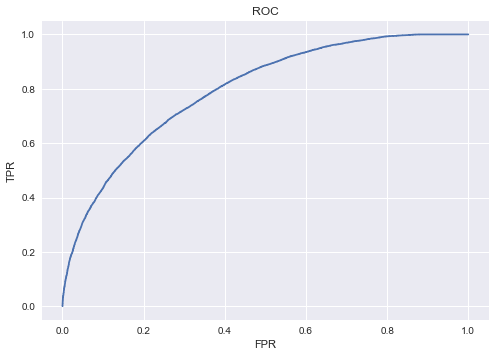

In [360]:
fpr, tpr, thresholds = roc_curve(ytest, y_pred_prob[:,1])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC")
print('AUC', roc_auc_score(ytest, y_pred_prob[:,1]))

In [ ]:
fpr, tpr, thresholds = roc_curve(ytest, y_pred_prob[:,1])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC")
print('AUC', roc_auc_score(ytest, y_pred_prob[:,1]))

### 3.2 Training and testing data preparation

In [306]:
y.flatten().shape

(119206,)

In [157]:
# Select predictor and target columns
predictors = []
predictors.extend([c for c in dfd.columns if c[0:5] == 'cat_t' ])
predictors.extend(['goal_log', 'name_wlen'])
#predictors.extend(['goal_log', 'staff_pick','name_wlen'])
predictors.extend(['name', 'blurb'])

target = ['succeeded']

In [158]:
# Split data to train and test sets
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
print(X.shape, Xtrain.shape, Xtest.shape, y.shape, ytrain.shape, ytest.shape)

df_train=dfd.sample(frac=0.8,random_state=200)
df_test=dfd.drop(df_train.index)

(149007, 17) (111755, 17) (37252, 17) (149007, 1) (111755, 1) (37252, 1)


### 3.3 Fit pipeline

In [ ]:
# Create predictor and target sets
X = dfd[predictors].values
y = dfd[target].values.astype(np.int)

In [11]:
df_train=dfd.sample(frac=0.8,random_state=200)
df_test=dfd.drop(df_train.index)

In [12]:
print(df_train.shape, df_test.shape, dfd.shape)

(119206, 48) (29801, 48) (149007, 48)


### 3.2 Train Naive Bayes on name and blurb data

In [82]:
vectorizer = CountVectorizer(min_df=2, max_df=2000)

# project name
Xn = vectorizer.fit_transform(df_train.name).tocsc()
#fn_names = vectorizer.get_feature_names()

# project blurb
dfn.blurb.fillna('', inplace=True)
Xb = vectorizer.fit_transform(df_train.blurb).tocsc()
#fb_names = vectorizer.get_feature_names()

#y = df_train.succeeded.values.astype(np.int)
y = df_train.staff_pick.values.astype(np.int)

print(Xn.shape, Xb.shape, y.shape)#, len(fn_names), len(fb_names))

(119206, 24661) (119206, 35717) (119206,)


In [83]:
#the grid of parameters to search over
param_grid = {'alpha':np.logspace(0.1, 100, 10)}
              
#mnb = BernoulliNB()
mnb = MultinomialNB()

mnb_cv = GridSearchCV(mnb, param_grid, cv=5, verbose=1)

# train and predict names
mnb_cv.fit(Xn, y)
pn = mnb_cv.predict_proba(Xn)[:,1]
print('Best alpha', mnb_cv.best_params_)
print('Best score', mnb_cv.best_score_)

# train and predict blurbs
mnb_cv.fit(Xb, y)
pb = mnb_cv.predict_proba(Xb)[:,1]
print('Best alpha', mnb_cv.best_params_)
print('Best score', mnb_cv.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.9s finished


Best alpha {'alpha': 158489319246.11172}
Best score 0.893495293861
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best alpha {'alpha': 158489319246.11172}
Best score 0.893495293861


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.1s finished


In [84]:
df_train['xn'] = np.log(pn/(1-pn))
df_train['xb'] = np.log(pb/(1-pb))

In [122]:
predictors = []
#predictors.extend([c for c in dfd.columns if c[0:5] == 'cat_t' ])
#predictors.extend([c for c in dfd.columns if c[0:5] == 'count' ])
#predictors.extend(['goal_log', 'staff_pick','name_wlen', 'xn', 'xb'])
predictors.extend(['name_wlen'])
#predictors.extend(['goal_log','name_wlen', 'xn', 'xb'])
#predictors.extend(['name_wlen', 'xn', 'xb'])

#predictors.extend(['staff_pick'])

In [123]:
Xtrain = df_train[predictors]
#ytrain = df_train.succeeded.values.astype(np.int)
ytrain = df_train.staff_pick.values.astype(np.int)


#Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
#print(X.shape, Xtrain.shape, Xtest.shape, y.shape, ytrain.shape, ytest.shape)

In [124]:
logreg = LogisticRegression(penalty='l1', verbose=1, C=0.1)#, warm_start=True)

#print(logreg.intercept_, logreg.coef_)
logreg.fit(Xtrain, ytrain)
#logreg.intercept_ = 2.299
#logreg.coef_ = np.reshape(np.array([-0.6687]), (1,-1))
print(logreg.intercept_, logreg.coef_)

[LibLinear][-2.65915544] [[ 0.09124064]]


In [125]:
y_pred = logreg.predict(Xtrain)
y_pred_prob = logreg.predict_proba(Xtrain)
print('Score:', logreg.score(Xtrain, ytrain))

Score: 0.893495293861


In [104]:
print('CV score:', cross_val_score(logreg, Xtrain, ytrain, cv=5))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]CV score: [ 0.89346531  0.89350279  0.89350279  0.89350279  0.89350279]


In [21]:
y_pred = logreg.predict(Xtest)
y_pred_prob = logreg.predict_proba(Xtest)
print('Score:', logreg.score(Xtest, ytest))
#y_pred_cv = cross_val_predict(logreg, X, y, cv=3)
#y_pred_cv

NameError: name 'Xtest' is not defined

In [ ]:
fpr, tpr, thresholds = roc_curve(ytest, y_pred_prob[:,1])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC")
print('AUC', roc_auc_score(ytest, y_pred_prob[:,1]))

In [ ]:
logregcv = LogisticRegressionCV(verbose=1, cv=3, Cs=[0.1, 1.0, 100.0])#, warm_start=True)
logregcv.fit(X, y)
print(logregcv.coef_)

In [ ]:
y_pred = logregcv.predict(Xtest)
y_pred_prob = logregcv.predict_proba(Xtest)
print('Score:', logregcv.score(Xtest, ytest))
fpr, tpr, thresholds = roc_curve(ytest, y_pred_prob[:,1])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC")
print('AUC', roc_auc_score(ytest, y_pred_prob[:,1]))

### 3.2 Naive Bayes for text analysis 

In [ ]:
# Vectorize project names and blurbs
#vectorizer = TfidfVectorizer(min_df=1)
vectorizer = CountVectorizer(min_df=2, max_df=2000)

# project name
Xn = vectorizer.fit_transform(dfn.name).tocsc()
fn_names = vectorizer.get_feature_names()

# project blurb
dfn.blurb.fillna('', inplace=True)
Xb = vectorizer.fit_transform(dfn.blurb).tocsc()
fb_names = vectorizer.get_feature_names()

y = dfn.succeeded.values.astype(np.int)

print(Xn.shape, Xb.shape, y.shape, len(fn_names), len(fb_names))

Simple training without cross validation

In [ ]:
# NB for names

# train-test split
Xntrain, Xntest, ytrain, ytest = train_test_split(Xn, y)

# Create instance of multinomial naive bayes
mnb_n = MultinomialNB()

# fit to training data
mnb_n.fit(Xntrain, ytrain)

print("Train set score:", mnb_n.score(Xntrain, ytrain))
print("Test set score:", mnb_n.score(Xntest, ytest))

In [ ]:
# NB for blurbs

# train-test split
Xbtrain, Xbtest, ytrain, ytest = train_test_split(Xb, y)

# Create instance of multinomial naive bayes
mnb_b = MultinomialNB()

# fit to training data
mnb_b.fit(Xbtrain, ytrain)

print("Train set score:", mnb_b.score(Xbtrain, ytrain))
print("Test set score:", mnb_b.score(Xbtest, ytest))

In [ ]:
#the grid of parameters to search over
param_grid = {'alpha':np.logspace(0.1, 100, 10)}
              
mnb = MultinomialNB()
mnb_cv = GridSearchCV(mnb, param_grid, cv=5, verbose=1)
mnb_cv.fit(Xn, y)

print('Best alpha', mnb_cv.best_params_)
print('Best score', mnb_cv.best_score_)

In [ ]:
mnb_cv.predict_proba(Xn)[:,1]

In [ ]:
pn = mnb_n.predict_proba(Xn)[:,1]
pb = mnb_b.predict_proba(Xb)[:,1]

In [ ]:
xn = np.log(pn/(1-pn))
xb = np.log(pb/(1-pb))

In [ ]:
print(xn, xb)

In [ ]:
dfd['xn'] = xn

In [ ]:
dfd['xb'] = xb

In [ ]:
dfd.head()

In [ ]:
predictors.extend(['xn', 'xb'])

In [ ]:
Xx = dfd[predictors]
y = dfd.succeeded.values.astype(np.int)

Xtrain, Xtest, ytrain, ytest = train_test_split(Xx, y)
print(X.shape, Xtrain.shape, Xtest.shape, y.shape, ytrain.shape, ytest.shape)

In [ ]:
logreg = LogisticRegression(verbose=1, C=0.1)#, warm_start=True)

logreg.fit(Xtrain, ytrain)
#logreg.intercept_ = 2.299
#logreg.coef_ = np.reshape(np.array([-0.6687]), (1,-1))
print(logreg.intercept_, logreg.coef_)

In [ ]:
y_pred = logreg.predict(Xtest)
y_pred_prob = logreg.predict_proba(Xtest)
print('Score:', logreg.score(Xtest, ytest))

In [ ]:
print('CV score:', cross_val_score(logreg, Xx, y, cv=5))

In [ ]:
y_pred = logregcv.predict(Xtest)
y_pred_prob = logregcv.predict_proba(Xtest)
print('Score:', logregcv.score(Xtest, ytest))
fpr, tpr, thresholds = roc_curve(ytest, y_pred_prob[:,1])
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC")
print('AUC', roc_auc_score(ytest, y_pred_prob[:,1]))

Modify score function to replace accuracy with precision?

In [ ]:
Interpretability, based on rigorous statistical principles, minimal number of parameters, predictions of microstructures
Well justified choice of optimization loss function base on rigorous statistical principles.

In [143]:
x = np.linspace(0.0, 1.0, 100)

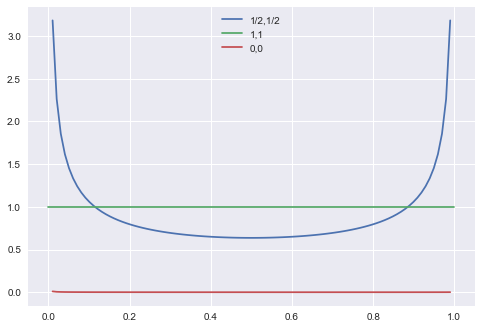

In [146]:
from scipy.stats import beta
plt.plot(x, beta.pdf(x, 1/2, 1/2), label='1/2,1/2')
plt.plot(x, beta.pdf(x, 1, 1), label='1,1')
plt.plot(x, beta.pdf(x, 0.0001, 1/2), label='0,0')
plt.legend()